<a href="https://colab.research.google.com/github/carlosfmorenog/CDSMOTE-NONBIN-Symbols/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Multiclass Imbalanced Dataset Classification of Symbols from Piping and Instrumentation Diagrams

## Please reference the following paper:

* Elyan E, Moreno-García CF, Johnston P. Symbols in Engineering Drawings (SiED): An Imbalanced Dataset Benchmarked by Convolutional Neural Networks. In: Engineering Applications of Neural Networks (EANN). 2020. p. 215–24.

## Bibtex Citation

@inproceedings{Elyan2020,
author = {Elyan, Eyad and Moreno-Garc{\'{i}}a, Carlos Francisco and Johnston, Pamela},
booktitle = {Engineering Applications of Neural Networks (EANN)},
doi = {10.1007/978-3-030-48791-1},
isbn = {9783030487911},
keywords = {Imbalance Datasets Multiclass,P{\&}ID,classification,cnn,engineering drawings,id,imbalanced dataset,multiclass,p},
mendeley-tags = {Imbalance Datasets Multiclass,P{\&}ID},
pages = {215--224},
title = {{Symbols in Engineering Drawings (SiED): An Imbalanced Dataset Benchmarked by Convolutional Neural Networks}},
year = {2020}
}


In [1]:
## Import necessary packages
import sys
import numpy as np
import csv
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from itertools import chain

To test this method, we will use P&ID symbols extracted from two different drawing standards. We collected a total of $7702$ symbols corresponding to $37$ different classes. All symbols have been reshaped to $100 \times 100$, then binarised using `cv2.threshold` with `threshold=180` and flattened as $1 \times 10 000$ vectors to be stored in the *.csv file

![Fig 1. Sample of Symbols to Classify](https://www.dropbox.com/s/xd2gvg2aavg5tfw/fig2.png?raw=1)

To apply the CDSMOTE method, we need to define the following parameters:

* `classdecomp`: You can select different algorithms to cluster in the CD step. According to our experimental results, DBSCAN yields the best outcomes for sentiment analysis given the cosine similarity distance calculation.
* `oversampler`: You can choose between SMOTE or ADASYN for the oversampling step. Currently we have always implemented SMOTE, hence the name of the method
* `n_clusters`: Number of clusters in which the majority class will be decomposed. In this case, we will set it to 10.
* `threshold`: If the number of samples of class is `threshold` samples below the average number of samples per class (after the decomposition step), then the class is selected for augmentation.

In [2]:
classdecomp = 'Kmeans' # 'FCmeans', 'FCmeansOptimised' and 'DBSCAN' also available 
oversampler = 'SMOTE' #'ADASYN' also available
threshold = 10 # if samples in positive class are apart from average by more than this value, apply oversampling (Sec 3.2 paper)
n_clusters = 10 # used in option "majority"

**STEP 1:** Loading the dataset

                     Class  Number of Samples
0                Arrowhead                241
1     Arrowhead + Triangle                 83
2                      Box                  7
3         Continuity Label                288
4                  Control                 20
5            Control Valve                 60
6      Control Valve Globe                 23
7                   DB&BBV                144
8     DB&BBV + Valve Check                 39
9                   DB&BPV                113
10         ESDV Valve Ball                 88
11    ESDV Valve Butterfly                  7
12    ESDV Valve Slab Gate                  9
13      Exit to Atmosphere                 14
14       Flange + Triangle                 17
15            Flange Joint                419
16   Flange Single T-Shape                 64
17          Injector Point                 43
18                 Reducer                877
19            Rupture Disc                 10
20                  Sensor        

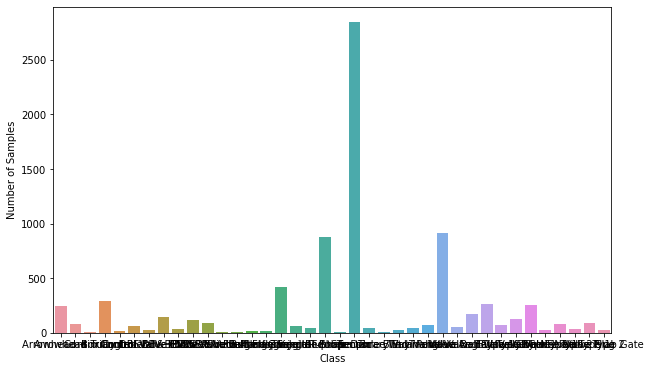

In [4]:
## 1. Load dataset (due to the size of the original repo, we will import it from a cloud location)
data_and_target = pd.read_csv('https://www.dropbox.com/s/sj277k4slmrv3qc/symbols_combined_pixel_red.csv?raw=1',
                             header = None)
data = data_and_target.iloc[:,:-1].values.tolist()
target = data_and_target.iloc[:,-1:].to_numpy().tolist()
target = list(chain.from_iterable(target))

## 2. Find majority and minority classes
majority_class = max(set(target), key=target.count)
minority_class = min(set(target), key=target.count)

## 3. Plot distribution of original dataset
#print('Dataset: '+str(dataset))
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target)))):
    cont = 0
    for j, label2 in enumerate(target):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target)])

# Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total samples: '+str(len(target)))
# Create a histogram using seaborn
sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
# Save the image
sns_plot.figure.set_size_inches(10, 6)
print('\nShowing class distribution bar chart...')
plt.show()

**STEP 2:** Apply class decomposition to the majority class (i.e. Sensors)

In [7]:
## Before applying the step, we will define some functions
# For computing Kv, there are four options, although in this example we will use computekv_majority only
def computekv_method4_1(target):
    '''This method follows the equation detailed in section 4.1 of the report to calculate k values'''
    import math
    print('\nCalculating k values...')
    ## Obtain the number of classes in label list and sort
    labelsIndexesUnique = list(set(target))
    labelsIndexesUnique.sort()
    ## For each class, count the number of instances and calculate ki
    k = []
    for label in labelsIndexesUnique:
        k.append(target.count(label))
    avgInst = sum(k)/len(k)
    k = [math.floor((ki/avgInst)+1) for ki in k]
    return k

def computekv_randomk(data, target):
    '''This method assigns random values to the k values from 1 to n, being n the number of samples in the class.'''
    import random
    k = []
    IndexesUnique = list(set(target))
    IndexesUnique.sort()
    for i, label in enumerate(IndexesUnique):
        ## Count the number of instances
        instances = 0
        for j in range(len(data)):
            if target[j]==label:
                instances+=1
        k.append(random.choice(range(instances)))
    return k

def computekv_randombinary(n_clusters, target):
    '''This method assigns a random value between either 1 (no clustering) or n_clusters (clustering) to the vector of k values.'''
    import random
    k = []
    for i in range(len(list(set(target)))):
        k.append(random.choice([[1,n_clusters]]))
    return k

def computekv_majority(data, target, n_clusters):
    '''This method finds the majority class and computes a vector of k values such that only the majority class is decomposed in 'n_clusters' clusters.'''
    IndexesUnique = list(set(target))
    IndexesUnique.sort()
    instances = [0]*len(IndexesUnique)
    k = [1]*len(IndexesUnique)
    ## Count the number of instances for each class
    for i, label in enumerate(IndexesUnique):
        for j in range(len(data)):
            if target[j]==label:
                instances[i]+=1
    ## Find the majority class
    majorityclass = instances.index(max(instances))
    k[majorityclass]=n_clusters
    return k

# For data clustering, we also have 4 options (kmeans, fcmeans, fcmeansoptimised 6 dbscan)
def clustdata_Kmeans(data, target, k):
    print('\nClass decomposition by applying k-means...')    
    from sklearn.cluster import KMeans
    target_clust = ['']*len(target)
    IndexesUnique = list(set(target))
    IndexesUnique.sort()
    for i, label in enumerate(IndexesUnique):
        if k[i]==1:
            print('No clustering performed for class '+str(label)+'.')
        else:
            print('Number of clusters for class '+str(label)+': '+str(k[i]))
        ## Split the dataset
        data_tocluster = []
        data_tocluster_index = []
        for j, dat in enumerate(data):
            if target[j]==label:
                data_tocluster.append(dat)
                data_tocluster_index.append(j)
        if 1<k[i]<=len(data_tocluster):
                ## Apply k-means to the list    
                kmeans = KMeans(n_clusters=k[i], random_state=0).fit(data_tocluster)
                for n, m in enumerate(kmeans.labels_):
                    target_clust[data_tocluster_index[n]]=str(label)+'_c'+str(m)
        else:
            for m in data_tocluster_index:
                target_clust[m]=str(label)+'_c0'
    return target_clust


def clustdata_FCmeans(data, target, k):
    print('\nClass decomposition by applying FCmeans...')
    import skfuzzy as fuzz
    import numpy as np
    target_clust = ['']*len(target)
    IndexesUnique = list(set(target))
    IndexesUnique.sort()
    for i, label in enumerate(IndexesUnique):
        if k[i]==1:
            print('No clustering performed for class '+str(label)+'.')
        else:
            print('Number of clusters for class '+str(label)+': '+str(k[i]))
        ## Split the dataset
        data_tocluster = []
        data_tocluster_index = []
        for j, dat in enumerate(data):
            if target[j]==label:
                data_tocluster.append(dat)
                data_tocluster_index.append(j)
        data_tocluster_transpose = np.asarray(data_tocluster).transpose()
        if k[i]!=1 and len(data_tocluster)>1:
        ## Apply fcmeans
            _, u, _, _, _, _, fpc = fuzz.cluster.cmeans(data_tocluster_transpose, k[i], 2, error=0.005, maxiter=1000, init=None)
            cluster_membership = np.argmax(u, axis=0)
            for n, m in enumerate(cluster_membership):
                target_clust[data_tocluster_index[n]]=str(label)+'_c'+str(m)
        else:
            for m in data_tocluster_index:
                target_clust[m]=str(label)+'_c0'
    return target_clust

def clustdata_FCmeansOptimised(data, target, k, max_nclusters = 10):
    print('\nClass decomposition by applying FCmeans Optimised...')
    import skfuzzy as fuzz
    import numpy as np
    target_clust = ['']*len(target)
    IndexesUnique = list(set(target))
    IndexesUnique.sort()
    for i, label in enumerate(IndexesUnique):
        fpcs = []
        us = []
        ## Split the dataset
        data_tocluster = []
        data_tocluster_index = []
        for j, dat in enumerate(data):
            if target[j]==label:
                data_tocluster.append(dat)
                data_tocluster_index.append(j)
        data_tocluster_transpose = np.asarray(data_tocluster).transpose()
        if k[i]!=1 and len(data_tocluster)>1:
        ## Apply fcmeans for 2 to max_nclusters
            for ncenters in range(2,max_nclusters):
                if ncenters<=len(data_tocluster):
                    _, u, _, _, _, _, fpc = fuzz.cluster.cmeans(data_tocluster_transpose, ncenters, 2, error=0.005, maxiter=1000, init=None)
                    fpcs.append(fpc)
                    us.append(u)
            ## Find the best clustering (maximum fpc value)
            best_ncenters = fpcs.index(max(fpcs))
            print('Maximum fpc score for class '+str(label)+': '+str("%.2f" % (max(fpcs))+' ('+str(best_ncenters+2)+' clusters)'))
            cluster_membership = np.argmax(us[best_ncenters], axis=0)        
            for n, m in enumerate(cluster_membership):
                target_clust[data_tocluster_index[n]]=str(label)+'_c'+str(m)
        else:
            print('No clustering performed for class '+str(label)+'.')
            for m in data_tocluster_index:
                target_clust[m]=str(label)+'_c0'
    return target_clust

def clustdata_DBSCAN(data, target, k, eps=0.5, min_samples=5):
    print('\nClass decomposition by applying DBSCAN...')
    from sklearn.cluster import DBSCAN
    target_clust = ['']*len(target)
    IndexesUnique = list(set(target))
    IndexesUnique.sort()
    for i, label in enumerate(IndexesUnique):
        ## Split the dataset
        data_tocluster = []
        data_tocluster_index = []
        for j, dat in enumerate(data):
            if target[j]==label:
                data_tocluster.append(dat)
                data_tocluster_index.append(j)
        if k[i]!=1 and len(data_tocluster)>1:
        ## Apply DBSCAN
            db = DBSCAN(eps, min_samples).fit(data_tocluster)
            cluster_membership = db.labels_
            n_clusters = len(set(cluster_membership))
            min_samples+=1
            print('Number of clusters found for class '+str(label)+': '+str(n_clusters))
            for n, m in enumerate(cluster_membership):
                target_clust[data_tocluster_index[n]]=str(label)+'_c'+str(m)
        else:
            print('No clustering performed for class '+str(label)+'.')
            for m in data_tocluster_index:
                target_clust[m]=str(label)+'_c0'
    return target_clust


Class decomposition by applying k-means...
No clustering performed for class Arrowhead.
No clustering performed for class Arrowhead + Triangle.
No clustering performed for class Box.
No clustering performed for class Continuity Label.
No clustering performed for class Control.
No clustering performed for class Control Valve.
No clustering performed for class Control Valve Globe.
No clustering performed for class DB&BBV.
No clustering performed for class DB&BBV + Valve Check.
No clustering performed for class DB&BPV.
No clustering performed for class ESDV Valve Ball.
No clustering performed for class ESDV Valve Butterfly.
No clustering performed for class ESDV Valve Slab Gate.
No clustering performed for class Exit to Atmosphere.
No clustering performed for class Flange + Triangle.
No clustering performed for class Flange Joint.
No clustering performed for class Flange Single T-Shape.
No clustering performed for class Injector Point.
No clustering performed for class Reducer.
No cluste

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No clustering performed for class Spectacle Blind.
No clustering performed for class Temporary Strainer.
No clustering performed for class Three Way Valve.
No clustering performed for class Tie In Point.
No clustering performed for class Triangle.
No clustering performed for class Valve.
No clustering performed for class Valve Angle.
No clustering performed for class Valve Ball Type 1.
No clustering performed for class Valve Ball Type 2.
No clustering performed for class Valve Butterfly Type 1.
No clustering performed for class Valve Check.
No clustering performed for class Valve Globe Type 1.
No clustering performed for class Valve Globe Type 2.
No clustering performed for class Valve Needle Type 1.
No clustering performed for class Valve Needle Type 2.
No clustering performed for class Valve Plug.
No clustering performed for class Valve Slab Gate.
                        Class  Number of Samples
0     Arrowhead + Triangle_c0                 83
1                Arrowhead_c0           

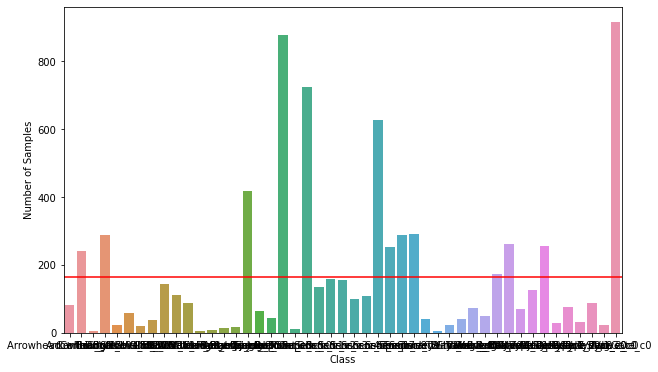

In [8]:
## 1. Calculate k vector (for class decomposition)
k = computekv_majority(data, target, n_clusters)

## 2. Cluster the data
if classdecomp.lower()=='kmeans':
    target_cd = clustdata_Kmeans(data, target, k)
elif classdecomp.lower()=='fcmeans':
    target_cd = clustdata_FCmeans(data, target, k)
elif classdecomp.lower()=='fcmeansoptimised':
     target_cd = clustdata_FCmeansOptimised(data, target, k, max_nclusters = 10)   
elif classdecomp.lower()=='dbscan':        
     target_cd = clustdata_DBSCAN(data, target, k, eps=0.5, min_samples=5)
else:
    print('Invalid clustering algorithm selected.')
    sys.exit()
    
## 3. Plot distribution after cd
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target_cd)))):
    cont = 0
    for j, label2 in enumerate(target_cd):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target_cd)])
# Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total samples: '+str(len(target_cd)))
# Create a histogram using seaborn
sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
# draw a line depicting the average
indexesUnique = list(set(target_cd))
indexesUnique.sort()
cdclassdist_count = []
cdclassdist_names = []
for cdclass in indexesUnique:
     cdclassdist_count.append(target_cd.count(cdclass))
     cdclassdist_names.append(cdclass)
average = sum(cdclassdist_count)/len(cdclassdist_count)
print('Average number of samples per class:', average)
plt.axhline(average, color='red')
# Save the image
sns_plot.figure.set_size_inches(10, 6)
print('\nShowing class distribution bar chart...')
plt.show()

**STEP 3:** Apply oversampling to all classes which have `average-threshold` samples or less

Oversampling class Arrowhead + Triangle_c0...
Oversampling class Box_c0...
Oversampling class Control Valve Globe_c0...
Oversampling class Control Valve_c0...
Oversampling class Control_c0...
Oversampling class DB&BBV + Valve Check_c0...
Oversampling class DB&BBV_c0...
Oversampling class DB&BPV_c0...
Oversampling class ESDV Valve Ball_c0...
Oversampling class ESDV Valve Butterfly_c0...
Oversampling class ESDV Valve Slab Gate_c0...
Oversampling class Exit to Atmosphere_c0...
Oversampling class Flange + Triangle_c0...
Oversampling class Flange Single T-Shape_c0...
Oversampling class Injector Point_c0...
Oversampling class Rupture Disc_c0...
Oversampling class Spectacle Blind_c0...
Oversampling class Temporary Strainer_c0...
Oversampling class Three Way Valve_c0...
Oversampling class Tie In Point_c0...
Oversampling class Triangle_c0...
Oversampling class Valve Angle_c0...
Oversampling class Valve Butterfly Type 1_c0...
Oversampling class Valve Check_c0...
Oversampling class Valve Globe Ty

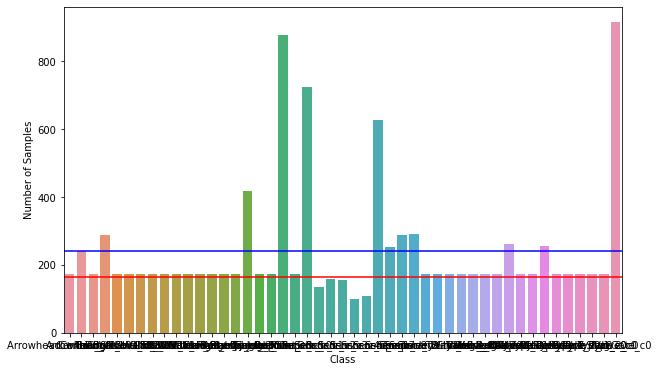

In [9]:
## 1. Calculate reference class (i.e. closest to the average and above it) for oversampling
c = np.inf
ref = majority_class+'_c0' # gets picked by default if none other accomplishes
for i,j in enumerate(cdclassdist_count):
    if abs(j-average)<c and j-average>=0:
        c = abs(j-average)
        ref = cdclassdist_names[i]

data_cdsmote = list(np.asarray(data)[(np.where(np.asarray(target)==majority_class))])
target_cdsmote = list(np.asarray(target_cd)[(np.where(np.asarray(target)==majority_class))])

## 2. For all non-majority classes (considering the original dataset), see if they are far (i.e. difference greater than the threshold) from the average (red line in the last plot)
flag = 0
for i, cdclassdist_name in enumerate(cdclassdist_names):
    if majority_class not in cdclassdist_name.split('_')[0]:
        if abs(average-cdclassdist_count[i])>threshold and average-cdclassdist_count[i]>=0:
            flag = 1
            print('Oversampling class '+str(cdclassdist_name)+'...')            
            ## 3. Create a sub-dataset that only contains the new majority and current non-minority classes
            data_majmin = []
            target_majmin = []
            for j, label in enumerate(target_cd):
                if label == cdclassdist_name or label == ref:
                    data_majmin.append(data[j])
                    target_majmin.append(label)
            ## 4. Do the oversampling
            if oversampler.lower() == 'smote':
                sm = SMOTE()
                data_over, target_over = sm.fit_resample(data_majmin, target_majmin) 
            elif oversampler.lower() == 'adasyn':
                ada = ADASYN()
                data_over, target_over = ada.fit_resample(data_majmin, target_majmin)
            else:
                print('Invalid oversampling algorithm.')
                sys.exit() 
            # Append the oversampled data to the new repository
            for j, label in enumerate(target_over):
                if label == cdclassdist_name:
                    data_cdsmote.append(list(data_over[j]))
                    target_cdsmote.append(label)
        else:
            # Append the not-oversampled
            for j, label in enumerate(target_cd):
                if label == cdclassdist_name:
                    data_cdsmote.append(list(data[j]))
                    target_cdsmote.append(label)
            
    
## 5. Plot distribution after smote
if flag == 1:
    histo = [['Class','Number of Samples']]
    for i, label1 in enumerate(sorted(list(set(target_cdsmote)))):
        cont = 0
        for j, label2 in enumerate(target_cdsmote):
            if label1 == label2:
                cont+=1
        histo.append([label1,cont])
    histo.append(['Total Samples', len(target_cdsmote)])

    ## Load as a panda
    histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
    print(histo_panda)
    print('Total samples: '+str(len(target_cdsmote)))
    ## Create a histogram using seaborn
    sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
    ## draw a line depicting the average
    indexesUnique = list(set(target_cdsmote))
    indexesUnique.sort()
    newestclassdist_count = []
    for newestclass in indexesUnique:
          newestclassdist_count.append(target_cdsmote.count(newestclass))
    average_new = sum(newestclassdist_count)/len(newestclassdist_count)
    print('New average number of samples per class:', average_new)
    plt.axhline(average, color='red')
    plt.axhline(average_new, color='blue')
    ## Save the image
    sns_plot.figure.set_size_inches(10, 6)
    print('\nShowing class distribution bar chart...')
    plt.show()
else:
    print('All non-majority classes are close to average. No oversampling was needed.')

**STEP 4:** Classification (using SVM), comparing the **weighted** *precision*, *recall* and *f1-score* of the original dataset versus the one generated through CDSMOTE. We apply a five fold cross validation.

In [10]:
import warnings; warnings.simplefilter('ignore')
print('\n')

accuracy_o_final = 0
accuracy_c_final = 0
recall_o_final = 0
recall_c_final = 0
precision_o_final = 0
precision_c_final = 0
f1_o_final = 0
f1_c_final = 0

## Split data/target and data_cdsmote/target_cdsmote (stratified and with many splits)
sss = StratifiedShuffleSplit(n_splits=5, 
                             test_size=0.3, random_state=42)

# Original data, only do on the first test for the dataset to save time
experiments = 0
for train_index, test_index in sss.split(data, target):
    # print(train_index, test_index)
    print('\nExperiment '+str(experiments+1)+' Original DB...')
    experiments+=1
    X_train_o, X_test_o = np.asarray(data)[train_index], np.asarray(data)[test_index]
    y_train_o, y_test_o = np.asarray(target)[train_index], np.asarray(target)[test_index]
    clf_o = svm.SVC(kernel='linear')
    clf_o.fit(X_train_o, y_train_o)
    y_pred_o = clf_o.predict(X_test_o)
    # Test         
    print("Precision Original DB:",metrics.precision_score(y_test_o, y_pred_o, average='weighted'))
    print("Recall Original DB:",metrics.recall_score(y_test_o, y_pred_o, average='weighted'))
    print("F1 Score Original DB:",metrics.f1_score(y_test_o, y_pred_o, average='weighted'))
    precision_o_final = precision_o_final + metrics.precision_score(y_test_o, y_pred_o, average='weighted')
    recall_o_final = recall_o_final + metrics.recall_score(y_test_o, y_pred_o, average='weighted')
    f1_o_final = f1_o_final + metrics.f1_score(y_test_o, y_pred_o, average='weighted')

    print('\n------')

# CDSMOTE data
experiments = 0
for train_index, test_index in sss.split(data_cdsmote, target_cdsmote):
    print('\nExperiment '+str(experiments+1)+' CDSMOTE DB...')
    experiments+=1
    X_train_c, X_test_c,  = np.asarray(data_cdsmote)[train_index], np.asarray(data_cdsmote)[test_index]
    y_train_c, y_test_c = np.asarray(target_cdsmote)[train_index], np.asarray(target_cdsmote)[test_index]
    # Train models
    clf_c = svm.SVC(kernel='linear')
    clf_c.fit(X_train_c, y_train_c)
    y_pred_c = clf_c.predict(X_test_c)
    # Test, making sure accuracy considers sub_classes as good
    for i,label in enumerate(y_pred_c):
          y_pred_c[i] = label.split('_')[0]
    for i,label in enumerate(y_test_c):
          y_test_c[i] = label.split('_')[0]
    print("Precision CDSMOTE DB:",metrics.precision_score(y_test_c, y_pred_c, average='weighted'))
    print("Recall CDSMOTE DB:",metrics.recall_score(y_test_c, y_pred_c, average='weighted'))
    print("F1 Score CDSMOTE DB:",metrics.f1_score(y_test_c, y_pred_c, average='weighted'))
    precision_c_final = precision_c_final + metrics.precision_score(y_test_c, y_pred_c, average='weighted')
    recall_c_final = recall_c_final + metrics.recall_score(y_test_c, y_pred_c, average='weighted')
    f1_c_final = f1_c_final + metrics.f1_score(y_test_c, y_pred_c, average='weighted')

print('\n')

# Final results
print('Final Results:')
print("Average Precision Original DB:",precision_o_final/experiments)
print("Average Recall Original DB:",recall_o_final/experiments)
print("Average F1 Score Original DB:",f1_o_final/experiments)
print("Average Precision CDSMOTE DB:",precision_c_final/experiments)
print("Average Recall CDSMOTE DB:",recall_c_final/experiments)
print("Average F1 Score CDSMOTE DB:",f1_c_final/experiments)




Experiment 1 Original DB...
Precision Original DB: 0.9531628073915369
Recall Original DB: 0.9498052790999567
F1 Score Original DB: 0.9476363921022607

------

Experiment 2 Original DB...
Precision Original DB: 0.9564496768110253
Recall Original DB: 0.9528342708784077
F1 Score Original DB: 0.9500074960141541

------

Experiment 3 Original DB...
Precision Original DB: 0.9551737337405147
Recall Original DB: 0.9511034184335785
F1 Score Original DB: 0.9479535909721091

------

Experiment 4 Original DB...
Precision Original DB: 0.9523344049575958
Recall Original DB: 0.9515361315447858
F1 Score Original DB: 0.9484953147318262

------

Experiment 5 Original DB...
Precision Original DB: 0.952431997702874
Recall Original DB: 0.9489398528775422
F1 Score Original DB: 0.9465845978138188

------

Experiment 1 CDSMOTE DB...
Precision CDSMOTE DB: 0.9857388613806556
Recall CDSMOTE DB: 0.9852420306965761
F1 Score CDSMOTE DB: 0.9853213671129905

Experiment 2 CDSMOTE DB...
Precision CDSMOTE DB: 0.98421

Notice the the *weighted f1-score* when classifying this dataset increases from 0.94 to 0.98!

In [11]:
import warnings; warnings.simplefilter('ignore')
# Printing the classification report of the fifth experiment of each case
from sklearn.metrics import classification_report
print('\nClassification Report (Original DB)')
print(classification_report(y_test_o, y_pred_o, target_names=list(set(target))))
print('\nClassification Report (CDSMOTE DB)')
print(classification_report(y_test_c, y_pred_c, target_names=list(set(target))))


Classification Report (Original DB)
                        precision    recall  f1-score   support

  DB&BBV + Valve Check       0.93      0.97      0.95        72
                Sensor       0.83      0.76      0.79        25
                DB&BBV       1.00      1.00      1.00         2
    Valve Globe Type 1       0.90      0.89      0.89        87
Valve Butterfly Type 1       1.00      0.83      0.91         6
  Arrowhead + Triangle       0.94      0.83      0.88        18
          Rupture Disc       1.00      0.29      0.44         7
       ESDV Valve Ball       0.90      0.84      0.87        43
                 Valve       1.00      0.58      0.74        12
     Valve Ball Type 2       0.97      0.88      0.92        34
       Three Way Valve       0.91      0.81      0.86        26
                DB&BPV       0.00      0.00      0.00         2
   Control Valve Globe       1.00      1.00      1.00         3
          Tie In Point       1.00      1.00      1.00         4
  

Moreover, we can see previously unfavoured classes (i.e. `spectacle blind` or `valve check`) have increased precision and recall respectively, while the majority class (i.e. `sensors`) also has an increased f1-score! 